In [1]:
import numpy as np
import numpy.ma as ma

from mpl_toolkits import mplot3d
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl
from numpy import arange,array,ones,linalg
from scipy.optimize import minimize
from scipy import ndimage
from scipy import stats

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.nddata import bitmask
from astropy.nddata.bitmask import BitFlagNameMap
import math
from tqdm import tqdm

import copy

from scipy.ndimage import gaussian_filter1d

In [2]:
import os
current_directory = os.getcwd()
print(current_directory)

/global/u1/j/jlargett/DESI_SGA/Morphology


In [3]:
SGA_Param_Data = Table.read('SGA_Asym_Data.fits')
SGA_Param_Data

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,COLOR G-Z,COLOR G-R,COLOR R-Z,R50_R,m(r50)_G,m(r50)_Z,m(r50)_R,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_G_r50_r90,C_INDEX_R_r50_r90,C_INDEX_Z_r50_r90,r90_R,r50_G,r90_G,r50_Z,r90_Z,GINI_G,GINI_R,GINI_Z,Asymmetry_G,Asymmetry_R,Asymmetry_Z
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344

In [4]:
# Path to a random image in NERSC
f1 = math.trunc(SGA_Param_Data['RA'][1])
f2 = math.trunc((1000*SGA_Param_Data['RA'][1]))
f3 = math.trunc((100000*SGA_Param_Data['RA'][1]))
f4 = 'm' if SGA_Param_Data['DEC'][1] < 0 else 'p'
f5 = abs(math.trunc((100000*SGA_Param_Data['DEC'][1])))
path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/{:03d}/{:06d}/{:08d}{}{:07d}.fits'.format(f1,f2,f3,f4,f5)
fits_file = fits.open(path)
image = fits_file[0].data
bit_mask = fits_file[1].data

In [5]:
print(f"Image Shape: {image.shape}")
print(f"Bitmask Shape: {bit_mask.shape}")

Image Shape: (3, 227, 227)
Bitmask Shape: (227, 227)


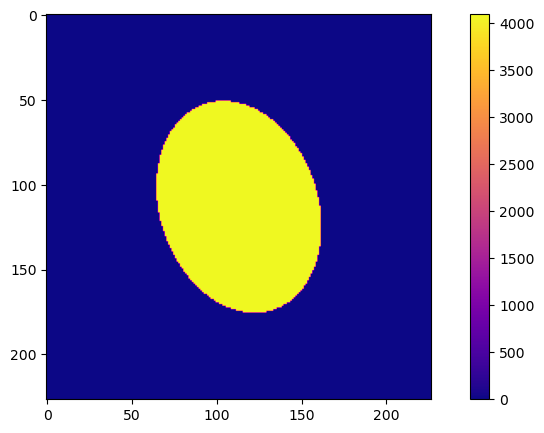

In [6]:
# Showing image 
plt.rcParams["figure.figsize"] = (10, 5)
plt.imshow(bit_mask, cmap='plasma')
plt.colorbar()

In [7]:
# Reshape the data
if image.shape[0] == 3:
    image_data = np.transpose(image, (1, 2, 0))
print(f"Image Shape: {image_data.shape}")

Image Shape: (227, 227, 3)


In [8]:
fits_file.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


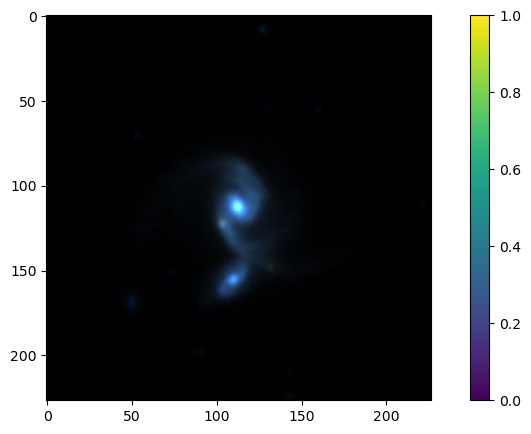

In [9]:
# Showing normal image 
plt.rcParams["figure.figsize"] = (10, 5)
plt.imshow(image_data)
plt.colorbar()

In [10]:
# Bits in the dict
MASKBITS = dict(
    NPRIMARY   = 0x1,   # not PRIMARY
    BRIGHT     = 0x2,
    SATUR_G    = 0x4,
    SATUR_R    = 0x8,
    SATUR_Z    = 0x10,
    ALLMASK_G  = 0x20,
    ALLMASK_R  = 0x40,
    ALLMASK_Z  = 0x80,
    WISEM1     = 0x100, # WISE masked
    WISEM2     = 0x200,
    BAILOUT    = 0x400, # bailed out of processing
    MEDIUM     = 0x800, # medium-bright star
    GALAXY     = 0x1000, # SGA large galaxy
    CLUSTER    = 0x2000, # Cluster catalog source
    SATUR_I    = 0x4000,
    ALLMASK_I  = 0x8000,
    SUB_BLOB   = 0x10000,
)

In [11]:
# Generate bitmask to apply to image
condition = bit_mask & MASKBITS['GALAXY'] != 0
mask_ = condition.astype(int)

In [12]:
# Generate bitmask to apply to image
condition2 = mask_ & (MASKBITS['BRIGHT'] | MASKBITS['SATUR_G'] | MASKBITS['SATUR_R'] | MASKBITS['SATUR_Z'] | MASKBITS['WISEM1'] | MASKBITS['WISEM2']) != 0
mask_2 = mask_ & ~condition2

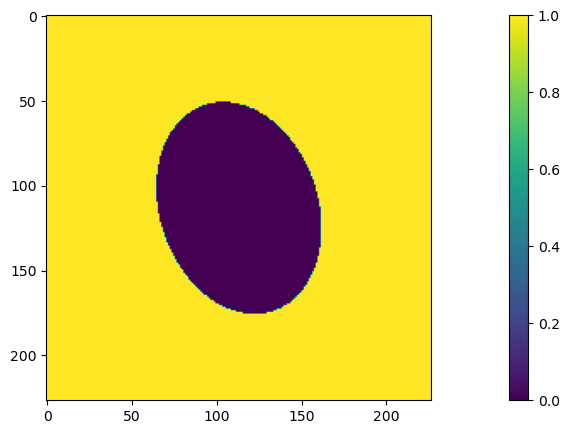

In [13]:
# Showing mask
plt.rcParams["figure.figsize"] = (20, 5)
plt.imshow(~(mask_2.astype(bool)))
plt.colorbar();

In [14]:
mask = np.dstack([mask_2.astype(bool), mask_2.astype(bool), mask_2.astype(bool)])
print(f"Mask Shape: {mask.shape}")
mimage_data = ma.array(image_data, mask=~mask)
print(f"Masked Image Shape: {mimage_data.shape}")

Mask Shape: (227, 227, 3)
Masked Image Shape: (227, 227, 3)


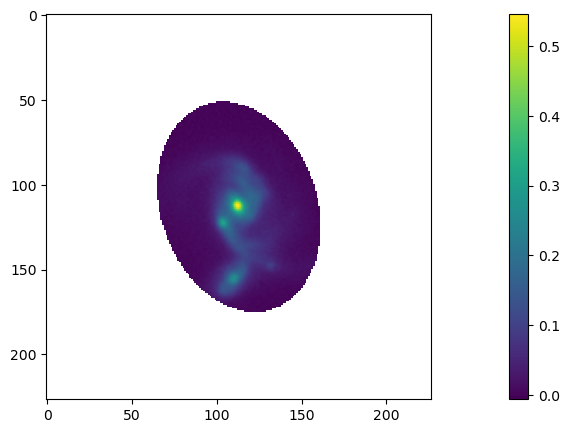

In [15]:
# showing masked image
plt.rcParams["figure.figsize"] = (20, 5)
plt.imshow(mimage_data[:,:,0])
plt.colorbar();

In [16]:
# color images
mg_image = ma.array(image_data[:,:,0], mask=~mask_2.astype(bool))
mr_image = ma.array(image_data[:,:,1], mask=~mask_2.astype(bool))
mz_image = ma.array(image_data[:,:,2], mask=~mask_2.astype(bool))

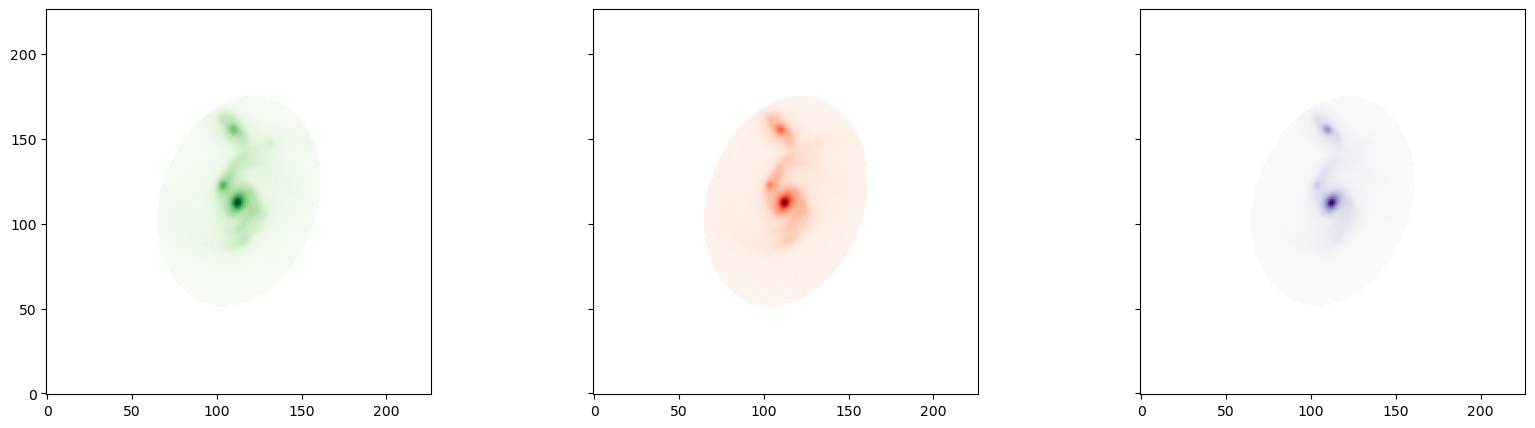

In [17]:
plt.figure()
ax1=plt.subplot(131)
plt.imshow(mg_image, origin='lower', cmap='Greens')
plt.subplot(132, sharey=ax1)
plt.imshow(mr_image, origin='lower', cmap='Reds')
plt.tick_params('y', labelleft=False)
plt.subplot(133, sharey=ax1)
plt.imshow(mz_image, origin='lower', cmap='Purples')
plt.tick_params('y', labelleft=False);

In [18]:
print(f"Shape of image_data: {image_data.shape}")
print(f"Shape of mg_image: {mg_image.shape}")
print(f"Shape of mimage_data: {mimage_data.shape}")
print(type(mg_image))

Shape of image_data: (227, 227, 3)
Shape of mg_image: (227, 227)
Shape of mimage_data: (227, 227, 3)
<class 'numpy.ma.core.MaskedArray'>


In [19]:
from scipy.ndimage import zoom
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Create a list to store indices of processed galaxies
processed_galaxies = []
no_bitmask = []
no_image_path = []
image_shape_unknown = []

# Create a deep copy of the original catalog
SGA_Param_Data_Copy = copy.deepcopy(SGA_Param_Data)

n_galaxies = len(SGA_Param_Data)

SGA_Param_Data_Copy['M20_G'] = np.NaN * np.ones(n_galaxies)
SGA_Param_Data_Copy['M20_R'] = np.NaN * np.ones(n_galaxies)
SGA_Param_Data_Copy['M20_Z'] = np.NaN * np.ones(n_galaxies)

galaxy_range = range(0, 5)

for i in tqdm(galaxy_range, desc="Processing Galaxies", unit="galaxy", leave=True):
    f1 = math.trunc(SGA_Param_Data_Copy['RA'][i])
    f2 = math.trunc((1000*SGA_Param_Data_Copy['RA'][i]))
    f3 = math.trunc((100000*SGA_Param_Data_Copy['RA'][i]))
    f4 = 'm' if SGA_Param_Data_Copy['DEC'][i] < 0 else 'p'
    f5 = abs(math.trunc((100000*SGA_Param_Data_Copy['DEC'][i])))
    path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/{:03d}/{:06d}/{:08d}{}{:07d}.fits'.format(f1,f2,f3,f4,f5)
    
    if os.path.exists(path):
        fits_file = fits.open(path, ignore_missing_simple=True, ignore_missing_end=True)
        
        try:
            fits_file[1].data
        except:
            no_bitmask.append(path)
            var_exists = False
        else:
            var_exists = True
            
        if var_exists: 
            image = fits_file[0].data
            bit_mask = fits_file[1].data
            fits_file.close()
    
            #print("image shape:", image.shape, "bitmask shape:", bit_mask.shape)
    
            # reshape the data
            # checking to see if the galaxy has 3 color channels
            if image.shape[0] == 3:
                # the tuple swaps the 1st and 3rd dimensions, resulting in a new array, and assigns this array to the variable image_data
                image_data = np.transpose(image, (1, 2, 0))
                #print("image_data shape:", image_data.shape)
                fits_file.close()

                # generate bitmask to apply to image
                condition = bit_mask & MASKBITS['GALAXY'] != 0
                mask_int = condition.astype(int)
                #print("mask_int:", mask_int)
                
                # filtering out specific pixels in an image based on these additional conditions
                condition2 = mask_int & (MASKBITS['BRIGHT'] | MASKBITS['SATUR_G'] | MASKBITS['SATUR_R'] | MASKBITS['SATUR_Z'] | MASKBITS['WISEM1'] | MASKBITS['WISEM2']) != 0
                mask_2 = mask_int & ~condition2

                # make the mask (318, 318, 3), where the third dimension represents the same 2D mask array duplicated three times
                mask = np.dstack([mask_2.astype(bool), mask_2.astype(bool), mask_2.astype(bool)])
                mimage_data = ma.array(image_data, mask=~mask)
                #print("mask shape:", mask.shape)
                #print("mimage_data shape:", mimage_data.shape)
                
                # mask each color
                mg_image = ma.array(image_data[:,:,0], mask=~mask_2.astype(bool))
                mr_image = ma.array(image_data[:,:,1], mask=~mask_2.astype(bool))
                mz_image = ma.array(image_data[:,:,2], mask=~mask_2.astype(bool))

                # calculate M20 parameter

                # extract the image shape and coordinates for g, r, and z.
                rowsg, colsg = mg_image.shape
                yg, xg = np.mgrid[0:rowsg, 0:colsg]
                squared_distanceg = xg**2 + yg**2

                rowsr, colsr = mr_image.shape
                yr, xr = np.mgrid[0:rowsr, 0:colsr]
                squared_distancer = xr**2 + yr**2

                rowsz, colsz = mz_image.shape
                yz, xz = np.mgrid[0:rowsz, 0:colsz]
                squared_distancez = xz**2 + yz**2
                
                # Calculate the total second-order moments for each band
                moment_g = np.sum(mg_image * squared_distanceg)
                moment_r = np.sum(mr_image * squared_distancer)
                moment_z = np.sum(mz_image * squared_distancez)

                #print("M20tot for g band:", moment_g)
                #print("M20tot for r band:", moment_r)
                #print("M20tot for z band:", moment_z)

                # Flatten the images and sort the pixel values in descending order
                flattened_g = np.ravel(mg_image)
                flattened_r = np.ravel(mr_image)
                flattened_z = np.ravel(mz_image)
                
                # sorting the indices of the flattened array in descending order based on the corresponding pixel values
                sorted_indices_g = np.argsort(flattened_g)[::-1]
                sorted_indices_r = np.argsort(flattened_r)[::-1]
                sorted_indices_z = np.argsort(flattened_z)[::-1]

                # calculating the cumulative sum of the sorted pixel values multiplied by squared distance
                cumulative_sum_g = np.cumsum(flattened_g[sorted_indices_g] * squared_distanceg.flatten()[sorted_indices_g])
                cumulative_sum_r = np.cumsum(flattened_r[sorted_indices_r] * squared_distancer.flatten()[sorted_indices_r])
                cumulative_sum_z = np.cumsum(flattened_z[sorted_indices_z] * squared_distancez.flatten()[sorted_indices_z])

                # find the index where the cumulative sum reaches 20% of the total second-order moment
                twenty_percent_index_g = np.argmax(cumulative_sum_g >= 0.2 * moment_g)
                twenty_percent_index_r = np.argmax(cumulative_sum_r >= 0.2 * moment_r)
                twenty_percent_index_z = np.argmax(cumulative_sum_z >= 0.2 * moment_z)

                # normalized M20 moment for each band
                normalized_m20_g = np.log10(np.sum(flattened_g[sorted_indices_g[:twenty_percent_index_g + 1]] * squared_distanceg.flatten()[sorted_indices_g[:twenty_percent_index_g + 1]]) / moment_g)
                normalized_m20_r = np.log10(np.sum(flattened_r[sorted_indices_r[:twenty_percent_index_r + 1]] * squared_distancer.flatten()[sorted_indices_r[:twenty_percent_index_r + 1]]) / moment_r)
                normalized_m20_z = np.log10(np.sum(flattened_z[sorted_indices_z[:twenty_percent_index_z + 1]] * squared_distancez.flatten()[sorted_indices_z[:twenty_percent_index_z + 1]]) / moment_z)

                # Append asymmetry values to the new columns in the copied catalog
                SGA_Param_Data_Copy[i]['M20_G'] = normalized_m20_g
                SGA_Param_Data_Copy[i]['M20_R'] = normalized_m20_r
                SGA_Param_Data_Copy[i]['M20_Z'] = normalized_m20_z

                # Append the index of the processed galaxy to the list
                processed_galaxies.append(i)

                #print("Galaxy processed!", i)
        
            else:
                image_shape_unknown.append(path)
    else: 
        no_image_path.append(path)

Processing Galaxies: 100%|██████████| 5/5 [00:00<00:00, 58.99galaxy/s]


In [20]:
print(f"Galaxies with no bitmask: {len(no_bitmask)}")
print(f"Galaxies with no image path: {len(no_image_path)}")
print(f"Galaxies with an unknown image shape: {len(image_shape_unknown)}")
print(f"Galaxies successfully processed: {len(processed_galaxies)}")
print(f"All Galaxies Processed: {len(no_bitmask) + len(no_image_path) + len(image_shape_unknown) + len(processed_galaxies)}")
print(f"Total Galaxies: {len(SGA_Param_Data)}")

Galaxies with no bitmask: 0
Galaxies with no image path: 0
Galaxies with an unknown image shape: 0
Galaxies successfully processed: 5
All Galaxies Processed: 5
Total Galaxies: 383620


In [21]:
# print the list of processed galaxies after the loop
#print("Galaxies that were successfully processed:", processed_galaxies)

# check and print rows where asym_param_g, asym_param_r, and asym_param_z are not NaN
non_nan_rows = SGA_Param_Data_Copy[
    ~np.isnan(SGA_Param_Data_Copy['M20_G']) &
    ~np.isnan(SGA_Param_Data_Copy['M20_R']) &
    ~np.isnan(SGA_Param_Data_Copy['M20_Z'])
]

print(non_nan_rows)

SGA_ID  SGA_GALAXY ...        M20_R               M20_Z       
------ ----------- ... ------------------- -------------------
     2  SGA-2020 2 ...  -0.696473242540632 -0.6953430248684771
     3  SGA-2020 3 ... -0.6983727146996892 -0.6978131763186095
     4  SGA-2020 4 ... -0.6977490228113463 -0.6974949163848356
     7  SGA-2020 7 ...  -0.698403269063197 -0.6978616558293419
    18 SGA-2020 18 ... -0.6963324158045897 -0.6983083037028002


In [22]:
# save already processed rows and parameters in a fits file
SGA_Param_Data_Copy.write("SGA_M20_Data1.fits", format='fits', overwrite=True)